In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
from matplotlib.offsetbox import AnchoredText
from experiments.configs.regression_consts import VALID_UQ_METHODS, VALID_ESTIMATORS, MODELS, DATASETS, SINGLE_CONFORMAL_METHODS
plt.rcParams['text.usetex'] = True
plt.rcParams.update({
    "text.usetex": True,              # Use TeX for text rendering
    "font.family": "serif",
    "hatch.color": "white"
})
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:

def convert_results_to_df(results_dict):
   
    df = pd.DataFrame.from_dict(
        {(dataset, method, hyperparam): metrics
        for dataset, methods in results_dict.items()
        for (method, hyperparam), metrics in methods.items()},
        orient='index'
    )

    # Convert index into MultiIndex
    df.index = pd.MultiIndex.from_tuples(df.index, names=['Dataset', 'Method', 'Estimator'])

    # Reset index to move 'Dataset' to a normal column
    df = df.reset_index()

    # Pivot table to reshape
    df = df.pivot(index="Dataset", columns=["Method", "Estimator"])

    # Fix column ordering
    df.columns = df.columns.reorder_levels([1, 2, 0])  # Move metric to last level
    df = df.sort_index(axis=1)  # Sort for readability
    return df

# Load Results

In [4]:
train_size = 0.8
dataset_results = [pickle.load(open(f'../results/regression/aggregated_results/{dataset}_train_size_{train_size}_results.pkl', 'rb')) for dataset in DATASETS]
aggregated_results = pickle.load(open(f'../results/regression/aggregated_results/all_results_train_size_{train_size}.pkl', 'rb'))
df = convert_results_to_df(aggregated_results)
# Filter columns to only keep coverage_mean metric
df = df.loc[:, (slice(None), slice(None), ['mean_width_scaled_mean','mean_width_scaled_std','coverage_mean','coverage_std'])]

# Coverage 

In [5]:
df_coverage = df.loc[:, (slice(None), slice(None), ['coverage_mean','coverage_std'])]
# Create latex table for coverage 
df_coverage.to_latex(buf='coverage_table.tex', index=False)
# Create latex table for width 
df_width = df.loc[:, (slice(None), slice(None), ['mean_width_scaled_mean','mean_width_scaled_std'])]
df_width.to_latex(buf='width_table.tex', index=False)



In [ ]:
# Investigate coverages for 

# Plot Widths 

In [26]:
df_width = df.loc[:, (slice(None), slice(None), ['mean_width_scaled_mean'])]
df_width_split_conformal = df_width.loc[:, ('split_conformal', slice(None), slice(None))]
df_width_split_conformal.mean(axis=0) # XGBoost has lowest average width for split conformal 



Method           Estimator                           
split_conformal  AdaBoost      mean_width_scaled_mean    0.343580
                 ElasticNet    mean_width_scaled_mean    0.395557
                 ExtraTrees    mean_width_scaled_mean    0.316289
                 Lasso         mean_width_scaled_mean    0.395557
                 MLP           mean_width_scaled_mean    3.695655
                 OLS           mean_width_scaled_mean    0.352496
                 RandomForest  mean_width_scaled_mean    0.279146
                 Ridge         mean_width_scaled_mean    0.380113
                 XGBoost       mean_width_scaled_mean    0.235093
dtype: float64

In [27]:
df_width = df.loc[:, (slice(None), slice(None), ['mean_width_scaled_mean'])]
df_width_studentized_conformal = df_width.loc[:, ('studentized_conformal', slice(None), slice(None))]
df_width_studentized_conformal.mean(axis=0) # RandomForest has lowest average width for studentized conformal 


Method                 Estimator                           
studentized_conformal  AdaBoost      mean_width_scaled_mean    0.321307
                       ElasticNet    mean_width_scaled_mean    0.390925
                       ExtraTrees    mean_width_scaled_mean    0.275815
                       Lasso         mean_width_scaled_mean    0.390925
                       MLP           mean_width_scaled_mean    9.631628
                       OLS           mean_width_scaled_mean    0.354639
                       RandomForest  mean_width_scaled_mean    0.240990
                       Ridge         mean_width_scaled_mean    0.398207
                       XGBoost       mean_width_scaled_mean    0.406141
dtype: float64

array([[0.1344211 , 0.27149035, 0.06606612, 0.1721357 , 0.18721957,
        0.09312154, 0.12733561, 0.03023383, 0.12710969, 0.28252347,
        0.07553568, 0.00143552, 0.20101679, 0.13893391, 0.57066638,
        0.31471879, 0.19326958],
       [0.2007287 , 0.36655843, 0.08056352, 0.2474525 , 0.2543939 ,
        0.11729864, 0.14312871, 0.04406919, 0.31138745, 0.34804266,
        0.0997213 , 0.00310481, 0.25115826, 0.15988295, 0.75474686,
        0.33583593, 0.27850644],
       [0.34623343, 0.3483131 , 0.07621754, 0.31088284, 0.26486694,
        0.11279217, 0.15539973, 0.10519534, 0.22642158, 0.37799418,
        0.09048238, 0.00261546, 0.35884446, 0.16814883, 0.61439572,
        0.32132724, 0.21670159],
       [0.56185988, 0.63811963, 0.26042748, 0.52812605, 0.52303174,
        0.25219587, 0.32083425, 0.3487793 , 0.46520332, 0.5387173 ,
        0.22311642, 0.01033408, 0.82822758, 0.23766098, 0.92795883,
        0.47835776, 0.48950672]])

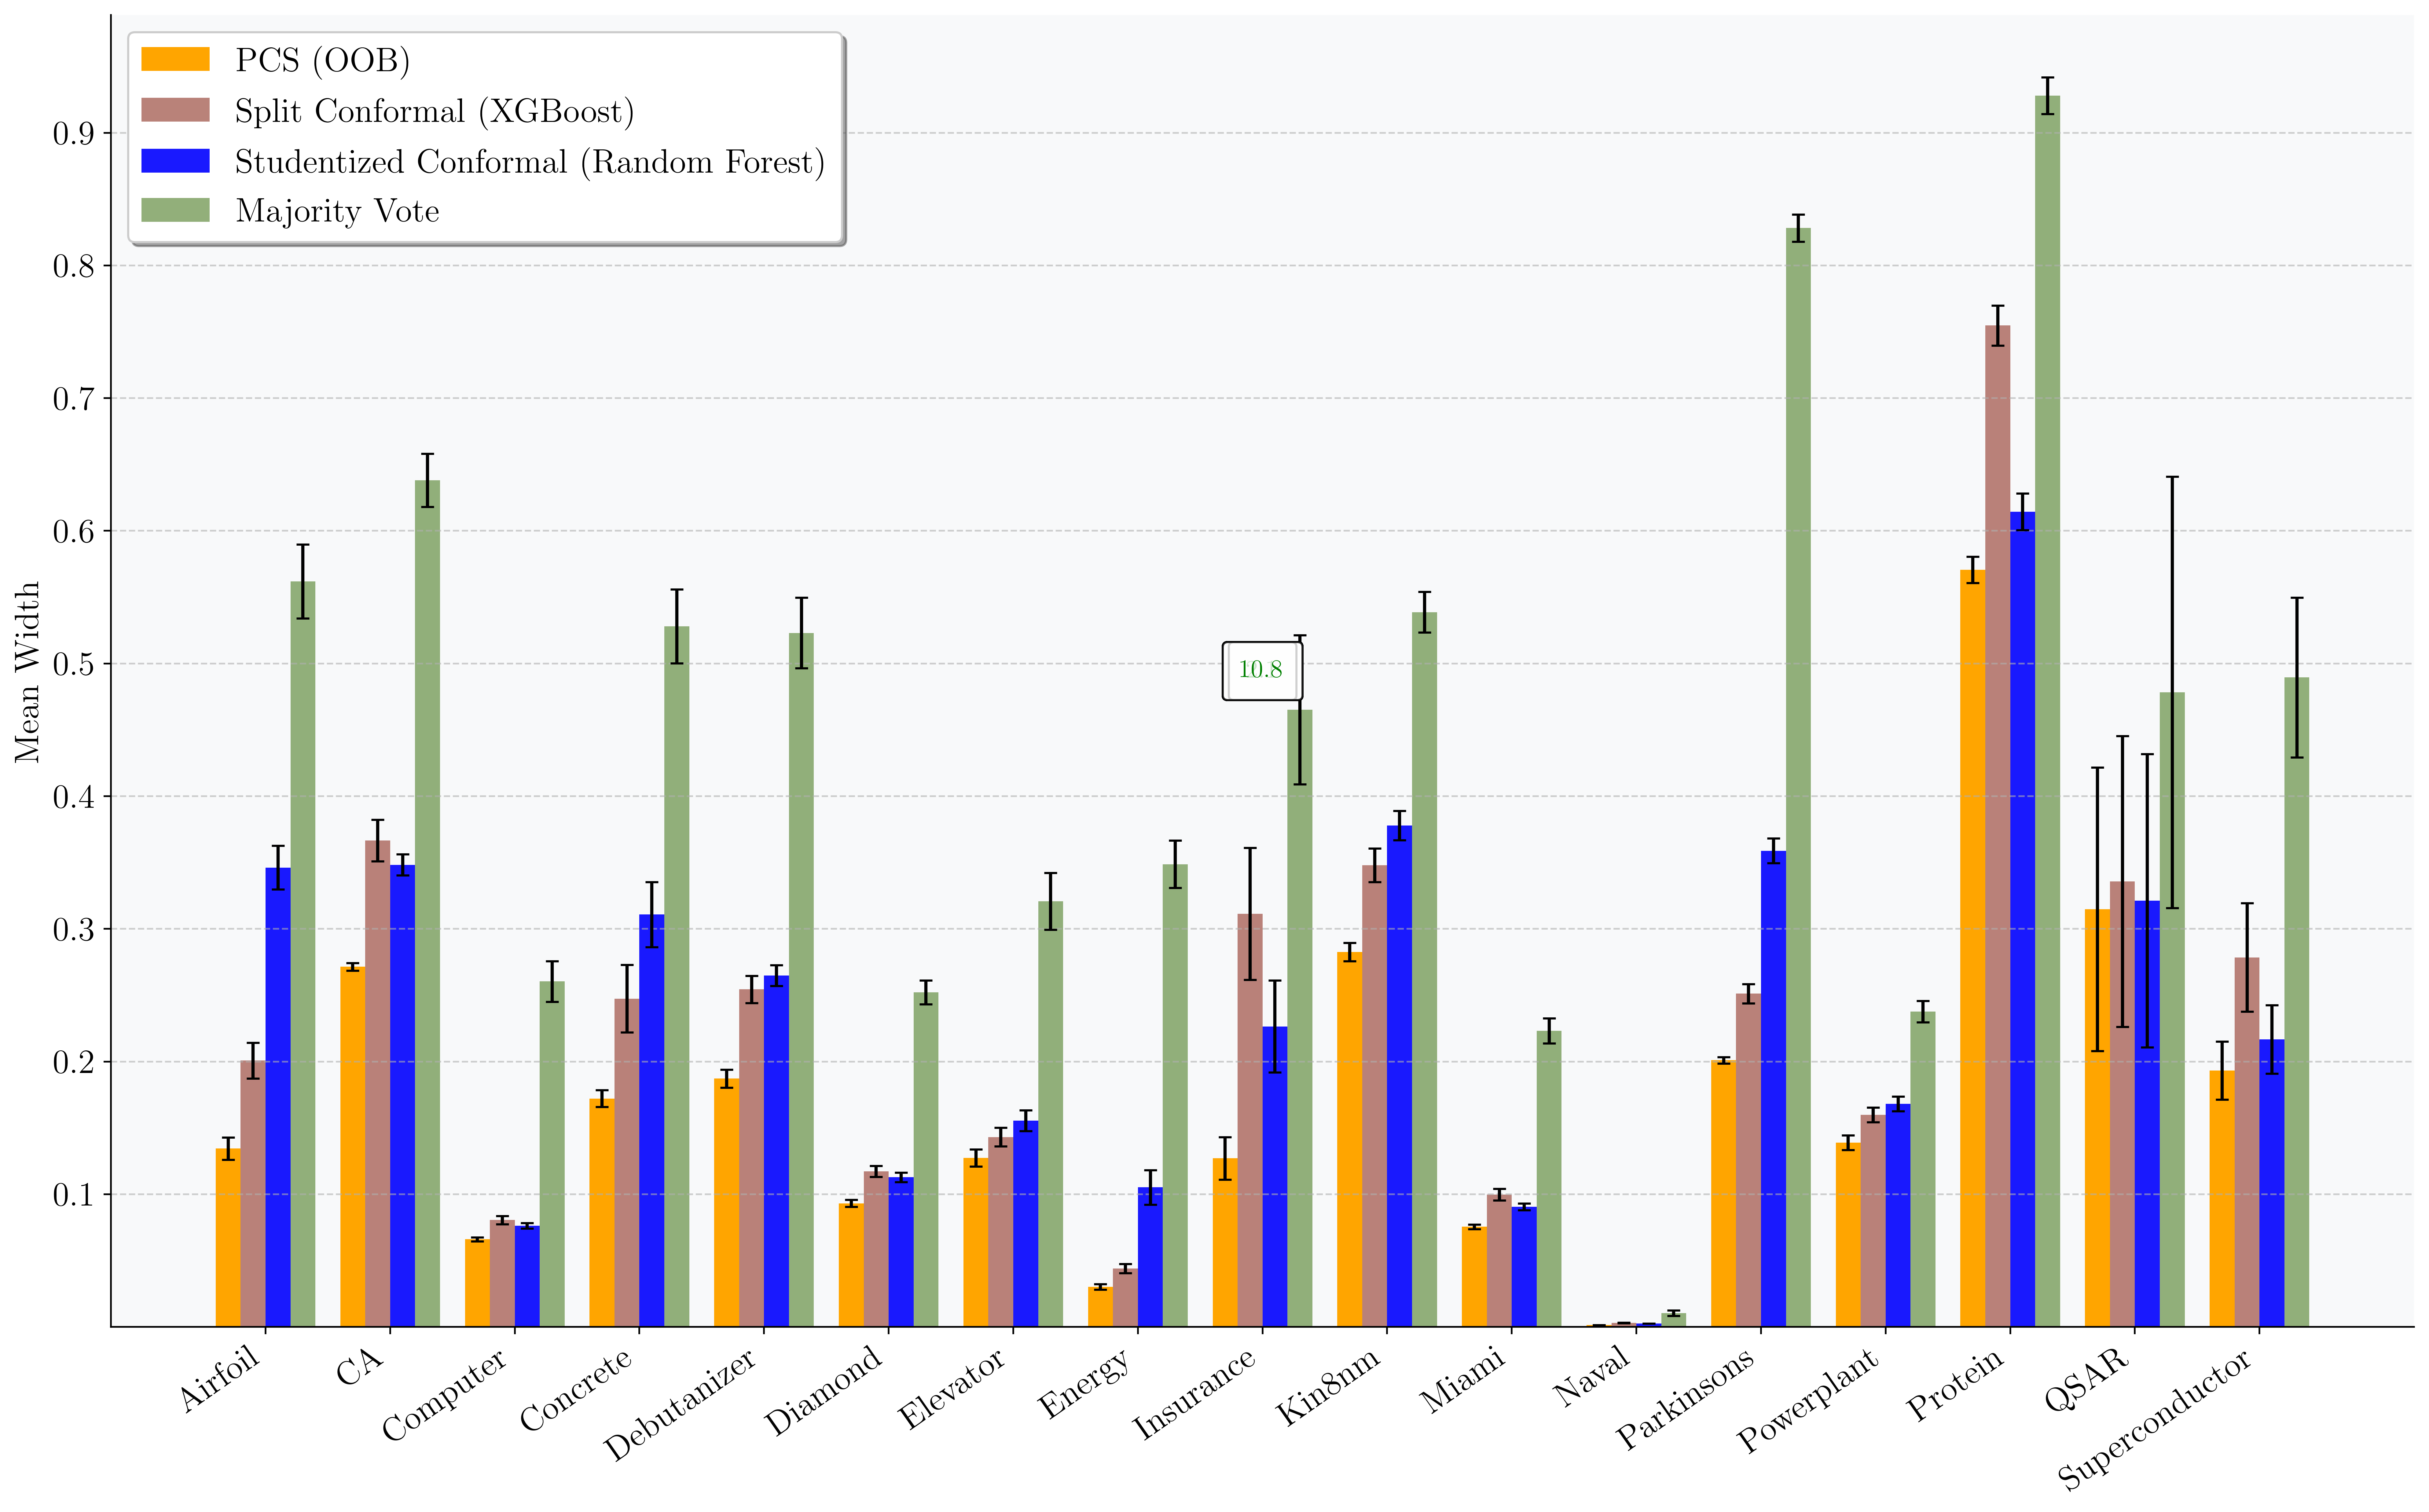

In [ ]:
# Create a bar plot of the mean_width_scaled_mean for each method and std deviation of the mean_width_scaled_mean. Only plot for pcs_uq, pcs_oob, split_conformal_xgb, studentized_conformal_rf, majority_vote
# Select methods to plot
methods_to_plot = [
    #('pcs_uq', ''),
    ('pcs_oob', ''),
    ('split_conformal', 'XGBoost'),
    ('studentized_conformal', 'RandomForest'),
    ('majority_vote', '')
]
legend_dict = {'majority_vote': 'Majority Vote', 'split_conformal_XGBoost': 'Split Conformal (XGBoost)', 'studentized_conformal_RandomForest': 'Studentized Conformal (Random Forest)', 'pcs_uq': 'PCS', 'pcs_oob': 'PCS (OOB)'}
data_dict = {'data_airfoil': 'Airfoil', 'data_ca_housing': 'CA', 'data_concrete': 'Concrete', 'data_parkinsons': 'Parkinsons',
             'data_energy_efficiency': 'Energy', "data_computer": "Computer", "data_kin8nm": "Kin8nm",
             "data_diamond": "Diamond", "data_elevator": "Elevator", "data_protein_structure": "Protein",
             "data_naval_propulsion": "Naval", "data_powerplant": "Powerplant", "data_qsar": "QSAR", 'data_superconductor': 'Superconductor',
             "data_miami_housing": "Miami", "data_debutanizer": "Debutanizer", "data_insurance": "Insurance"}
colors = {'PCS (OOB)': 'orange', 'Split Conformal (XGBoost)': '#B2746B', 'Studentized Conformal (Random Forest)': 'blue', 'Majority Vote': '#86a76c', 'PCS': 'gray'}
              
              
plt.figure(figsize=(16, 10), dpi=500)
# Add text next to each bar displaying % improve of PCS OOB over next best conformal method



# Set up transparency values
alpha_values = {}
for method, _ in methods_to_plot:
    if method == 'pcs_uq':
        alpha_values[method] = 0.6
    elif method == 'pcs_oob':
        alpha_values[method] = 1.0
    else:
        alpha_values[method] = 1.0 # Lower opacity for non-PCS methods

# Get data for plotting
plot_data = []
plot_errors = []
labels = []

for method, estimator in methods_to_plot:
    method_name = f"{method}_{estimator}" if estimator else method
    means = df.loc[:, (method, estimator, 'mean_width_scaled_mean')].values
    stds = df.loc[:, (method, estimator, 'mean_width_scaled_std')].values
    plot_data.append(means)
    plot_errors.append(stds)
    labels.append(legend_dict[method_name])

# Convert to numpy arrays
plot_data = np.array(plot_data)
plot_errors = np.array(plot_errors)

# Set up bar positions
n_methods = len(methods_to_plot)
n_datasets = len(df.index)
width = 0.4  # Width of bars
x = np.arange(n_datasets)

# Create color palette
#colors = plt.cm.Set3(np.linspace(0, 1, n_methods))
# Increase spacing between x-ticks by adjusting figure size and/or x positions

# Increase spacing between x positions
x = np.arange(n_datasets) * 2 # Multiply by 1.5 to increase gaps between bars

# Plot bars
for i in range(n_methods):
    plt.bar(x + i*width - (n_methods-1)*width/2, 
            plot_data[i], 
            width,
            label=labels[i],
            yerr=plot_errors[i],
            capsize=3,
            alpha=alpha_values[methods_to_plot[i][0]],
            color=colors[labels[i]])


# Customize plot
#plt.xlabel('Dataset', fontsize=16)
plt.ylabel('Mean Width', fontsize=16)
#plt.title('Prediction Interval Widths by Method and Dataset', fontsize=14, fontweight='bold', pad=20)

# Set x-axis ticks and labels
plt.xticks(x, [data_dict[dataset] for dataset in df.index], rotation=35, ha='right', fontsize=16)
plt.yticks(ticks = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], fontsize=16)

# Add some style elements
plt.gca().set_facecolor('#f8f9fa')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=True, fancybox=True, shadow=True, loc='upper left', fontsize=16)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

for i in range(n_datasets):
    pcs_oob_value = plot_data[0, i]  # PCS OOB value
    next_best_value = min([plot_data[1, i], plot_data[2, i], plot_data[3, i]])  # Next best conformal method value
    improvement = ((next_best_value - pcs_oob_value) / next_best_value) * 100  # Calculate % improvement
    
    # Create a text box with larger font
    text_str = f'{improvement:.1f}%'
    anchored_text = AnchoredText(text_str, loc='center', prop=dict(size=12, color='green'))
    anchored_text.patch.set_boxstyle("round,pad=0.3,rounding_size=0.2")
    anchored_text.patch.set_edgecolor('black')
    anchored_text.patch.set_alpha(0.8)
    anchored_text.xy = (x[i] + width - (n_methods-1)*width/2, pcs_oob_value + plot_errors[1, i] + 0.01)
    
    plt.gca().add_artist(anchored_text)

plot_data


In [ ]:
'), rotation=45, ha='right')
plt.legend(frameon=True, fancybox=True, shadow=True)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Adjust layout and add a light background color
plt.gca().set_facecolor('#f8f9fa')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# 